In [1]:
import datetime, itertools, sys
import pandas as ps
from subprocess import Popen, PIPE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import nltk

In [2]:
data = ps.read_csv("data/120k-utf8.csv", sep=';', header=None,
                   index_col=0,names=['id','title','text','cluster','date','publisher'])

## Предварительная очистка данных

In [3]:
data = data[~data["cluster"].isin(["-", "S", "Standard "])]
print("Число записей в таблице:", len(data))

Число записей в таблице: 61998


In [4]:
day_counts = {}
for _, row in data.iterrows():
    day_counts[row["date"]] = day_counts.get(row["date"], 0) + 1
max_date = max((count, date) for date, count in day_counts.items())[1]
print("Самый плотный день - {}, число записей: {}".format(max_date, day_counts[max_date]))

Самый плотный день - 2016-01-27, число записей: 37671


In [7]:
appropriate_days = [date for date, count in day_counts.items() if count == 37]
ch_day = appropriate_days[0]
data_1d = data[data["date"] == ch_day]
print("Выбранный день - {}, число записей: {}".format(ch_day, day_counts[ch_day]))

Выбранный день - 2015-08-25, число записей: 37


## Лемматизация текстов

In [8]:
m = Mystem()

def do_stem(df):
    cluster_index = {cluster: i for i, cluster in enumerate(df["cluster"].unique())}
    messages = ["".join(m.lemmatize(row["title"] + ". " + row["text"])) for _, row in df.iterrows()]
    clusters = [cluster_index[row["cluster"]] for _, row in df.iterrows()]
    return messages, clusters, cluster_index

In [9]:
messages, clusters, cluster_index = do_stem(data_1d)
print(messages[0])
print(len(messages), len(clusters))

непереносимый Facebook. речь идти о «широкий круг вопрос», связывать с исполнение компания российский законодательство, в тот число и обновлять закон «о персональный данные», вступать в сила с 1 сентябрь...

37 37


## Построение матрицы TF*IDF

In [10]:
tfidf_vectorizer = TfidfVectorizer(stop_words=nltk.corpus.stopwords.words('russian'))
tfidf_matrix = tfidf_vectorizer.fit_transform(messages)
print(tfidf_matrix.shape)

(37, 620)


## Кластеризация с отсечением на основе расстояния

In [11]:
print("Количество кластеров:", len(set(clusters)))

Количество кластеров: 24


In [12]:
def marks_to_pairwise(y_cls, p_cls):
    assert len(y_cls) == len(p_cls)
    res = {"ids": [], "y": [], "p": []}
    for i1, i2 in itertools.combinations(range(len(y_cls)), 2):
        res["ids"].append(sorted((i1, i2)))
        res["y"].append(bool(y_cls[i1] == y_cls[i2]))
        res["p"].append(bool(p_cls[i1] == p_cls[i2]))
    return ps.DataFrame(res, index=None)

In [13]:
def cross_class_report(res):
    classes = res["y"].unique()
    table = ps.DataFrame(index=classes, columns=classes)
    for true_cls in classes:
        tmp = res[res["y"] == true_cls]
        for pred_cls in classes:
            table[pred_cls][true_cls] = len(tmp[tmp["p"] == pred_cls])
    return table

In [14]:
%matplotlib inline

def plot_performance(tfidf_matrix, titles):
    dist_matrix = 1 - cosine_similarity(tfidf_matrix)
    linkage_matrix = ward(dist_matrix)
    
    fig, ax = plt.subplots(figsize=(15, 20))
    ax = dendrogram(linkage_matrix, orientation="right", labels=titles)
    
    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')

    plt.tight_layout() #show plot with tight layout
    return linkage_matrix

In [15]:
def print_performance(tfidf_matrix, clusters, cutoff):
    dist_matrix = 1 - cosine_similarity(tfidf_matrix)
    linkage_matrix = ward(dist_matrix)
    labels = fcluster(linkage_matrix, cutoff, criterion='distance')
    res = marks_to_pairwise(clusters, labels)
    print(classification_report(res["y"], res["p"]))
    print(cross_class_report(res), "\n\n")
    return res

             precision    recall  f1-score   support

      False       1.00      1.00      1.00       649
       True       0.85      1.00      0.92        17

avg / total       1.00      1.00      1.00       666

      False True 
False   646     3
True      0    17 




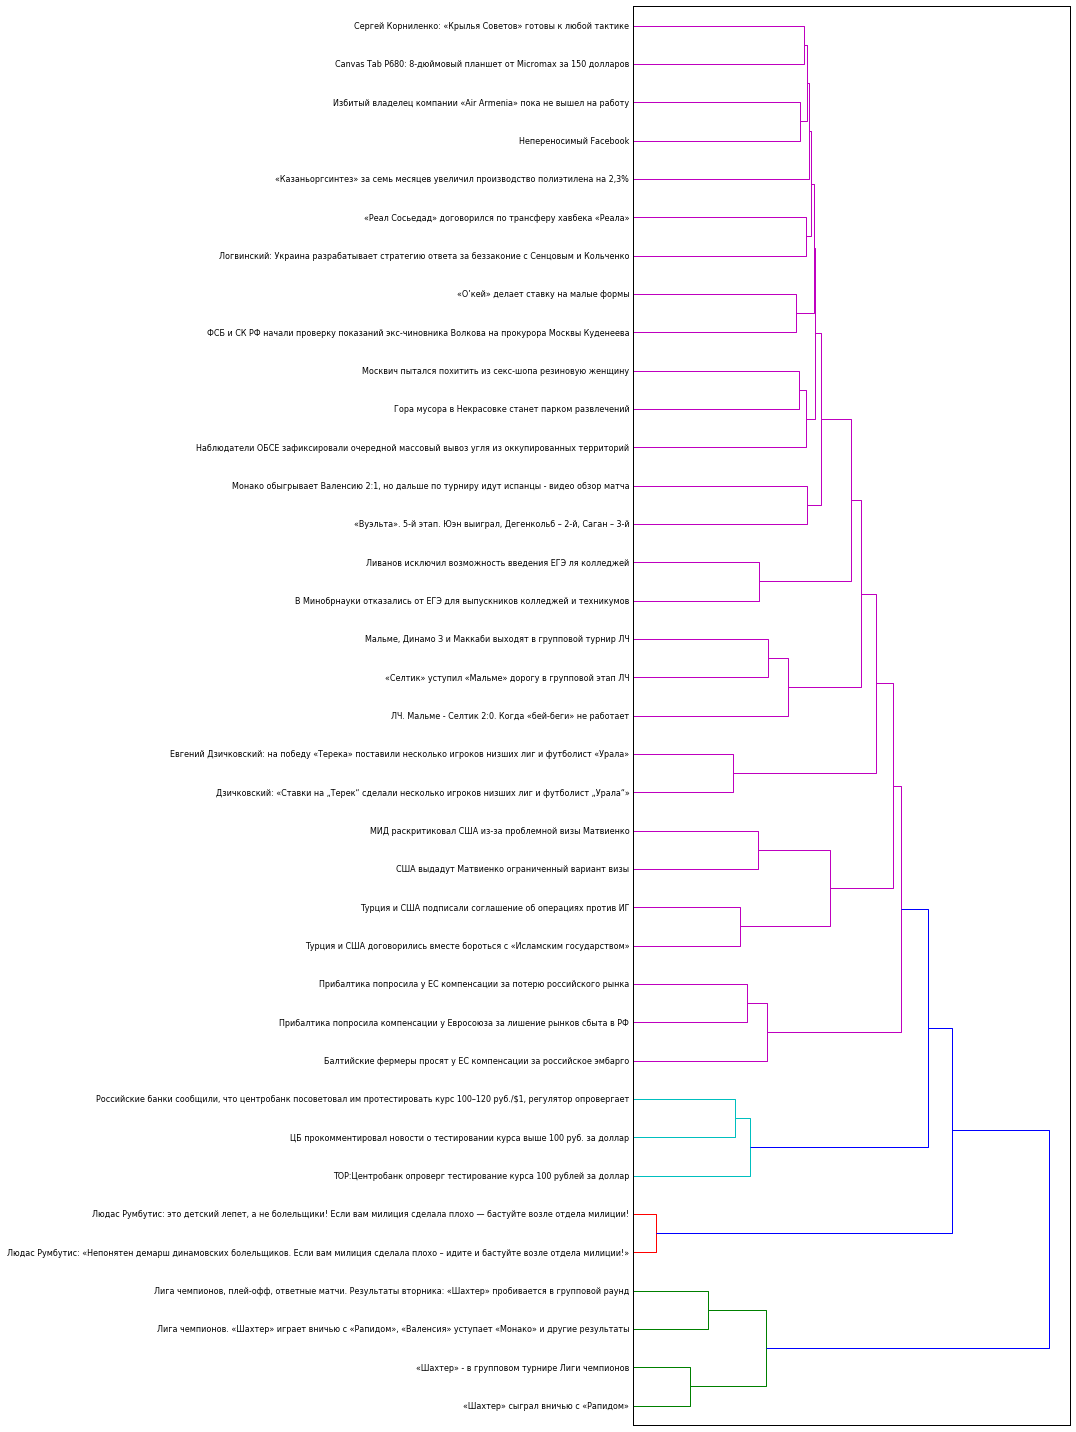

In [33]:
_ = plot_performance(tfidf_matrix, [row["title"] for _, row in data_1d.iterrows()])
_ = print_performance(tfidf_matrix, clusters, 1.3)

## Отсечение на основе расстояния для нескольких дней

In [34]:
def get_prec_recall_f(res, cls):
    pred = res[res["p"] == cls]
    prec = len(pred[pred["y"] == cls]) / len(pred)
    act = res[res["y"] == cls]
    rec = len(act[act["p"] == cls]) / len(act)
    return prec, rec, 2/(1/prec + 1/rec)

In [35]:
def get_data_for_day(day):
    data_1d = data[data["date"] == day]
    messages, clusters, cluster_index = do_stem(data_1d)
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(messages)
    
    return tfidf_matrix, clusters

In [36]:
def get_avg_prec_rec_f(scores):
    total_pairs = sum(s[3]*(s[3]-1)//2 for s in scores)
    avg_prec = sum(prec*(count*(count-1)//2)/total_pairs for prec, _, _, count in scores)
    avg_rec = sum(rec*(count*(count-1)//2)/total_pairs for _, rec, _, count in scores)
    avg_f = 2/(1/avg_prec + 1/avg_rec)
    return avg_prec, avg_rec, avg_f

In [39]:
days_to_check = ['2015-11-29', '2015-09-26', '2015-09-28', '2015-03-28', '2015-08-30',
                '2015-10-25', '2015-06-25', '2015-05-25', '2015-05-26', '2015-05-30']
mx = max(len(data[data["date"] == day]) for day in days_to_check)
print("Максимальный кластер:", mx)

Максимальный кластер: 788


In [41]:
all_res = []
for day in days_to_check:
    tfidf_matrix, clusters = get_data_for_day(day)
    print("День: {}\nЧисло новостей: {}\nКластеров:{}".format(day, tfidf_matrix.shape[0], len(set(clusters))))
    res = print_performance(tfidf_matrix, clusters, 1.3) 
    all_res.append(res)

День: 2015-11-29
Число новостей: 48
Кластеров:41
             precision    recall  f1-score   support

      False       1.00      0.99      0.99      1119
       True       0.38      0.67      0.48         9

avg / total       0.99      0.99      0.99      1128

      False True 
False  1109    10
True      3     6 


День: 2015-09-26
Число новостей: 48
Кластеров:34
             precision    recall  f1-score   support

      False       1.00      1.00      1.00      1111
       True       0.75      0.88      0.81        17

avg / total       0.99      0.99      0.99      1128

      False True 
False  1106     5
True      2    15 


День: 2015-09-28
Число новостей: 102
Кластеров:72
             precision    recall  f1-score   support

      False       1.00      1.00      1.00      5112
       True       0.59      0.87      0.70        39

avg / total       1.00      0.99      0.99      5151

      False True 
False  5088    24
True      5    34 


День: 2015-03-28
Число новостей: 104

In [42]:
total_res = ps.concat(all_res)
print(classification_report(total_res["y"], total_res["p"]))
print(cross_class_report(total_res), "\n\n")

             precision    recall  f1-score   support

      False       1.00      1.00      1.00    917477
       True       0.55      0.73      0.63      1283

avg / total       1.00      1.00      1.00    918760

        False True 
False  916725   752
True      346   937 




## Отсечение на основе размера кластера

In [43]:
def get_labels(linkage_matrix, n_samples, max_cls_size):
    clusters = {i: [i] for i in range(n_samples)}
    for i, row in enumerate(linkage_matrix):
        c1, c2, dist, cls_size = row
        if cls_size <= max_cls_size:
            clusters[n_samples+i] = clusters[c1] + clusters[c2]
            del clusters[c1]
            del clusters[c2]
    labels = [None] * n_samples
    for cls_num, objects in clusters.items():
        for o in objects:
            labels[o] = cls_num
    return labels

In [44]:
def print_performance_clsize(tfidf_matrix, clusters, max_clsize):
    dist_matrix = 1 - cosine_similarity(tfidf_matrix)
    linkage_matrix = ward(dist_matrix)
    labels = get_labels(linkage_matrix, tfidf_matrix.shape[0], max_clsize)
    res = marks_to_pairwise(clusters, labels)
    print(classification_report(res["y"], res["p"]))
    print(cross_class_report(res), "\n\n")
    return res

In [45]:
tfidf_matrix, clusters = get_data_for_day("2015-09-26")
print("День: {}\nЧисло новостей: {}\nКластеров:{}".format(day, tfidf_matrix.shape[0], len(set(clusters))))
_ = print_performance_clsize(tfidf_matrix, clusters, 3)

День: 2015-05-30
Число новостей: 48
Кластеров:34
             precision    recall  f1-score   support

      False       1.00      0.99      0.99      1111
       True       0.52      1.00      0.68        17

avg / total       0.99      0.99      0.99      1128

      False True 
False  1095    16
True      0    17 




In [46]:
days_to_check = ['2015-11-29', '2015-09-26', '2015-09-28', '2015-03-28', '2015-08-30',
                '2015-10-25', '2015-06-25', '2015-05-25', '2015-05-26', '2015-05-30']
all_res = []
for day in days_to_check:
    tfidf_matrix, clusters = get_data_for_day(day)
    print("День: {}\nЧисло новостей: {}\nКластеров:{}".format(day, tfidf_matrix.shape[0], len(set(clusters))))
    res = print_performance_clsize(tfidf_matrix, clusters, 3) 
    all_res.append(res)

День: 2015-11-29
Число новостей: 48
Кластеров:41
             precision    recall  f1-score   support

      False       1.00      0.97      0.99      1119
       True       0.18      0.67      0.28         9

avg / total       0.99      0.97      0.98      1128

      False True 
False  1091    28
True      3     6 


День: 2015-09-26
Число новостей: 48
Кластеров:34
             precision    recall  f1-score   support

      False       1.00      0.99      0.99      1111
       True       0.52      1.00      0.68        17

avg / total       0.99      0.99      0.99      1128

      False True 
False  1095    16
True      0    17 


День: 2015-09-28
Число новостей: 102
Кластеров:72
             precision    recall  f1-score   support

      False       1.00      0.99      1.00      5112
       True       0.46      0.92      0.62        39

avg / total       1.00      0.99      0.99      5151

      False True 
False  5070    42
True      3    36 


День: 2015-03-28
Число новостей: 104

In [47]:
total_res = ps.concat(all_res)
print(classification_report(total_res["y"], total_res["p"]))
print(cross_class_report(total_res), "\n\n")

             precision    recall  f1-score   support

      False       1.00      1.00      1.00    917477
       True       0.39      0.72      0.51      1283

avg / total       1.00      1.00      1.00    918760

        False True 
False  916048  1429
True      365   918 




## Проверка производительности на почти всей выборке

In [48]:
all_days = [day for day, count in day_counts.items() if count <= 1000]
print("Всего дней:", len(all_days))

Всего дней: 42


In [49]:
def print_performance_for_days(days, cutoff):
    all_res = []
    for day in days:
        tfidf_matrix, clusters = get_data_for_day(day)
        dist_matrix = 1 - cosine_similarity(tfidf_matrix)
        linkage_matrix = ward(dist_matrix)
        labels = fcluster(linkage_matrix, cutoff, criterion='distance')
        res = marks_to_pairwise(clusters, labels)
        all_res.append(res)
    total_res = ps.concat(all_res)
    print(classification_report(total_res["y"], total_res["p"]))
    print(cross_class_report(total_res))
    return res

In [50]:
res = print_performance_for_days(all_days, 1.3)

             precision    recall  f1-score   support

      False       1.00      1.00      1.00   2865153
       True       0.58      0.77      0.66      4288

avg / total       1.00      1.00      1.00   2869441

         False True 
False  2862770  2383
True       988  3300


In [51]:
def print_performance_for_days_clsize(days, max_clsize):
    all_res = []
    for day in days:
        tfidf_matrix, clusters = get_data_for_day(day)
        dist_matrix = 1 - cosine_similarity(tfidf_matrix)
        linkage_matrix = ward(dist_matrix)
        labels = get_labels(linkage_matrix, tfidf_matrix.shape[0], max_clsize)
        res = marks_to_pairwise(clusters, labels)
        all_res.append(res)
    total_res = ps.concat(all_res)
    print(classification_report(total_res["y"], total_res["p"]))
    print(cross_class_report(total_res))
    return res

In [52]:
res = print_performance_for_days_clsize(all_days, 3)

             precision    recall  f1-score   support

      False       1.00      1.00      1.00   2865153
       True       0.40      0.76      0.52      4288

avg / total       1.00      1.00      1.00   2869441

         False True 
False  2860201  4952
True      1015  3273


## Уточнение оценки производительности

In [53]:
all_days = [day for day, count in day_counts.items() if count <= 1000]
print("Всего дней:", len(all_days))

Всего дней: 42


In [54]:
def fair_performance_for_days(days, cutoff):
    counts = [[0, 0], [0, 0]] # [ожидание][реальность]
    for day in days:
        tfidf_matrix, clusters = get_data_for_day(day)
        dist_matrix = 1 - cosine_similarity(tfidf_matrix)
        linkage_matrix = ward(dist_matrix)
        labels = fcluster(linkage_matrix, cutoff, criterion='distance')
        
        for predicted, real, count in get_predicted_and_real_counts(clusters, labels):
            counts[predicted][real] += count
    
    data_days = data[data["date"].isin(days)]
    for clsname, df in data_days.groupby("cluster"):
        rows = [row for _, row in df.iterrows()]
        for r1, r2 in itertools.combinations(rows, 2):
            if r1["date"] != r2["date"]:
                counts[0][1] += 1
    
    counts[0][0] = len(data_days)*(len(data_days)-1)//2 - counts[0][1] - counts[1][0] - counts[1][1]
    
    table = ps.DataFrame(index=[0, 1], columns=[0, 1])
    for i in range(2):
        for j in range(2):
            table[i][j] = counts[j][i]
    
    report = ps.DataFrame(index=[0, 1],
                          columns=["precision", "recall", "f1-score"], dtype=float)
    for cls in range(2):
        report.loc[cls]["precision"] = counts[cls][cls]/(counts[cls][0] + counts[cls][1])
        report.loc[cls]["recall"] = counts[cls][cls]/(counts[0][cls] + counts[1][cls])
        report.loc[cls]["f1-score"] = 2/(1/report.loc[cls]["precision"] + 1/report.loc[cls]["recall"])
    
    return report, table

In [55]:
def get_predicted_and_real_counts(cls_real, cls_pred):
    assert len(cls_real) == len(cls_pred)
    counts = [[0, 0], [0, 0]] # [ожидание][реальность]
    for i1, i2 in itertools.combinations(range(len(cls_real)), 2):
        pred = int(cls_pred[i1] == cls_pred[i2])
        real = int(cls_real[i1] == cls_real[i2])
        counts[pred][real] += 1
    
    for pred in range(2):
        for real in range(2):
            yield pred, real, counts[pred][real]

In [56]:
report, table = fair_performance_for_days(all_days, 1.3)
print(report, "\n\n", table)

   precision    recall  f1-score
0   0.999980  0.999965  0.999972
1   0.580679  0.710900  0.639225 

           0     1
0  67139641  1342
1      2383  3300


In [57]:
def fair_performance_for_days_clsize(days, max_clsize):
    counts = [[0, 0], [0, 0]] # [ожидание][реальность]
    for day in days:
        tfidf_matrix, clusters = get_data_for_day(day)
        dist_matrix = 1 - cosine_similarity(tfidf_matrix)
        linkage_matrix = ward(dist_matrix)
        labels = get_labels(linkage_matrix, tfidf_matrix.shape[0], max_clsize)
        
        for predicted, real, count in get_predicted_and_real_counts(clusters, labels):
            counts[predicted][real] += count
    
    data_days = data[data["date"].isin(days)]
    for clsname, df in data_days.groupby("cluster"):
        rows = [row for _, row in df.iterrows()]
        for r1, r2 in itertools.combinations(rows, 2):
            if r1["date"] != r2["date"]:
                counts[0][1] += 1
    
    counts[0][0] = len(data_days)*(len(data_days)-1)//2 - counts[0][1] - counts[1][0] - counts[1][1]
    
    table = ps.DataFrame(index=[0, 1], columns=[0, 1])
    for i in range(2):
        for j in range(2):
            table[i][j] = counts[j][i]
    
    report = ps.DataFrame(index=[0, 1],
                          columns=["precision", "recall", "f1-score"], dtype=float)
    for cls in range(2):
        report.loc[cls]["precision"] = counts[cls][cls]/(counts[cls][0] + counts[cls][1])
        report.loc[cls]["recall"] = counts[cls][cls]/(counts[0][cls] + counts[1][cls])
        report.loc[cls]["f1-score"] = 2/(1/report.loc[cls]["precision"] + 1/report.loc[cls]["recall"])
    
    return report, table

In [58]:
report, table = fair_performance_for_days_clsize(all_days, 3)
print(report, "\n\n", table)

   precision    recall  f1-score
0   0.999980  0.999926  0.999953
1   0.397933  0.705084  0.508743 

           0     1
0  67137072  1369
1      4952  3273
